# 채소와 과일 이미지 분류
### Transfer Learning&Fintunig을 이용한 이미지 분류 모델 구현

###동기 및 진행 의도  

컴퓨터가 이미지를 분류하는 것은 사람이 직접 분류하는 것보다, 딥러닝을 기반으로 한 모델을 적용함으로써 시간 및 비용을 크게 절감 할 수 있다.

딥러닝 방식 중에서도 CNN 분류기를 통해 입력 이미지가 어떤 이미지인지 다중 분류하는 모델을 ResNet을 사용하여 Transfer learnig과 Finetunig 방식으로 구현함으로써 이미지 분류 딥러닝 과정에 대한 이해를 심화시키려함

---
###문제 정의 및 목표  
- 같은 채소라도 과육의 형태나 가공 여부 등 형태가 나뉘거나, 같은 형태의 채소라도 다양한 색상을 가지는 등 다양한 채소와 과일 이미지를 36개 클래스로  다중 분류함  

- Data generator를 이용한 데이터 증식 처리 구현  

- ResNet을 적용하여 더 깊고 안정적인 신경망 모델 실습  

- 검증 데이터셋 기준으로 90% 이상의 accuracy을 보이는 모델 생성 목표  


---
###데이터셋  
- 머신러닝 및 데이터 과학 커뮤니티 Kaggle에 업로드 되어있는 ['Fruits and Vegetables Image Recognition Dataset'](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition) 을 사용  

- 해당 데이터셋은 26종류의 채소와 10종류의 과일 이미지가 포함되어 있다

- 종류 별로 약 100개의 트레이닝 데이터와 약 10개의 검증, 테스트 데이터가 있다

- kaggle API Token을 이용하여 colab상에서 바로 데이터셋을 업로드하여 사용

In [ ]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow.keras.utils import plot_model 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
#colab과 Kaggle 연동 및 다운로드
!pip install kaggle  
from google.colab import files  
files.upload()  
!mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/  # Kaggle.json (Kaggle API Token) upload
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list -s english-french   
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition # 참고할 Kaggle API
!unzip englishfrench-translations.zip  
!ls
%cd "/content/"
!unzip -qq "/content/fruit-and-vegetable-image-recognition.zip"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
ref                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
dhruvildave/en-fr-translation-dataset             English-French Translation Dataset                  3GB  2021-02-09 19:27:52           1344         35  1.0              
devicharith/language-translation-englishfrench    Language Translation (English-French)               4MB  2020-04-08 11:35:32           1167         33  0.8235294        
digvijayyadav/frenchenglish                       English to French translations                      6MB  2020-07-27 16:22:20            310         17  1.0              
jannesklaas/frenchenglish-bilingual-pairs         French-English Bilingual Pairs                      6MB 

# 데이터셋 데이터 전처리

### 데이터 증식
학습 데이터의 양이 100개 가량으로 학습 데이터 부족으로 인한 과적합이 우려되었다.  
CNN모델 성능을 높이면서 과적합을 피할 수 있는 근본적인 해결책은 데이터의 다양성 증가라고 생각하여, Keras에서 지원하는 Image Data Generator를 사용하여 데이터를 증식 시켰다.  
  
감자 이미지를 회전, 확대, 이동, 반전 시킨다고 갑자기 감자가 고구마가 되진 않는다.  
하지만 픽셀 데이터 상으로는 완전히 다른  데이터이므로, 이 점을 이용하여 다양한 변형 이미지를 생성하여 데이터 증식과 데이터 변형에 대한 학습을 진행하였다.  



---


  
Keras에서 지원하는 'ImageDataGenerator' 클래스를 활용하여   
트레이닝 이미지를 상하좌우 이동, 확대, 회전, 뒤집기, 늘이기 등 6가지 버전으로 변형하여 데이터를 확장하였다.  
Image DataGenerator는 이미지를 학습시킬 때 학습데이터의 양이 적을 경우, 학습데이터를 조금씩 변형시켜서 학습데이터의 양을 늘리는 방식중에 하나이다.

Keras에서 지원하는 'flow_from_directory' 메소드를 활용하여 폴더 형태로 된 데이터 구조를 바로 호출하여 학습을 진행하였다.  


In [ ]:
train_data = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True, # 랜덤 가로 뒤짚기
                                  shear_range=True, # 랜덤으로 이미지 밀어 찌그러트리기
                                  rotation_range=30, #  -30 ~ 30도 범위 랜덤 회전
                                  zoom_range=0.3, # 랜덤 줌 범위 30%
                                  width_shift_range=0.3, # 30% 범위로 좌우 이동
                                  height_shift_range=0.3 # 30% 범위로 상하 이동
                                )
train_images = train_data.flow_from_directory('/content/train',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 3115 images belonging to 36 classes.


In [ ]:
val_data = ImageDataGenerator(rescale=1/255.)

val_images = val_data.flow_from_directory('/content/validation',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 351 images belonging to 36 classes.


In [ ]:
test_data = ImageDataGenerator(rescale=1/255.)

test_images = test_data.flow_from_directory('/content/test',
                                           target_size=(64,64),
                                           batch_size=32,
                                           class_mode='categorical')

Found 359 images belonging to 36 classes.


# 신경망 모델 구성

### ResNet 적용
데이터셋의 형태 범위가 다양하여 컴퓨터가 인식하기에는 난이도가 높다고 판단되므로   
imagenet에서 미리 훈련되어 저장된 네트워크인 pretrained network를 사용   

Keras.applications에서 제공하는 다양한 사전 학습 모델 중 신경망을 깊게 만들면서도 일반화 성능을 높일 수 있는 ResNet을 적용하고자 함  

ResNet은 2015년 Residual Network를 개발한 논문으로 identity mapping을 추가하는 기술을 통해 깊이가 매우 깊어진 모델의 학습을 가능하게 하였다. 사람의 정확도를 처음으로 능가하였다고 평가받는 모델이다.

그중에 ResNet101V2모델을 적용하여 더 깊으면서도 안정적이고 경량화된 모델을 만들려 시도함    


---
### 완전연결계층 추가와 L2 가중치 규제 적용  

미리 훈련된 가중치로 기본 모델을 인스턴스화함  

include_top = False로 설정하여 내가 만든 완전연결 계층을 추가적으로 쌓으려 함  

이후 기본 모델을 고정하고 위에




In [ ]:
resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(64,64,3))

for layer in resnet_v2.layers:
    layer.trainable = False
    
base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(36,kernel_regularizer=regularizers.l2(0.001), activation='softmax')(base_model)


model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
model.summary();

171317808/171317808 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                           

In [ ]:
history = model.fit(train_images,
              epochs=50,
              batch_size=32,
              validation_data=val_images,
              callbacks=ModelCheckpoint('Vegetable_classification.h5', 
                                        monitor='val_accuracy',mode='max',
                                        verbose=1, 
                                        save_best_only=True)
              )

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 3.6076 - accuracy: 0.2132
Epoch 1: val_accuracy improved from -inf to 0.46724, saving model to Vegetable_classification.h5
98/98 [==============================] - 168s 2s/step - loss: 3.6076 - accuracy: 0.2132 - val_loss: 2.1137 - val_accuracy: 0.4672
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 2.6701 - accuracy: 0.3313
Epoch 2: val_accuracy improved from 0.46724 to 0.57265, saving model to Vegetable_classification.h5
98/98 [==============================] - 140s 1s/step - loss: 2.6701 - accuracy: 0.3313 - val_loss: 1.6647 - val_accuracy: 0.5726
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 2.4968 - accuracy: 0.3689
Epoch 3: val_accuracy improved from 0.57265 to 0.58120, saving model to Vegetable_classification.h5
98/98 [==============================] - 137s 1s/step - loss: 2.4968 - accuracy: 0.3689 - val_loss: 1.6267 - val_accuracy: 0.5812
Epoch 4/50
98/98 [=============

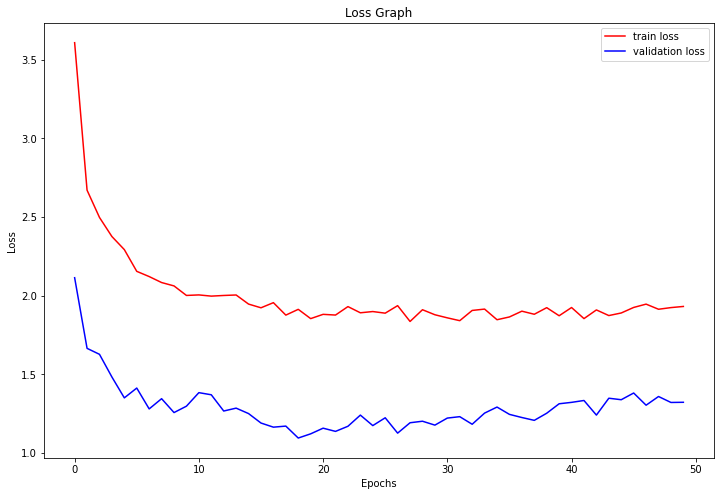

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

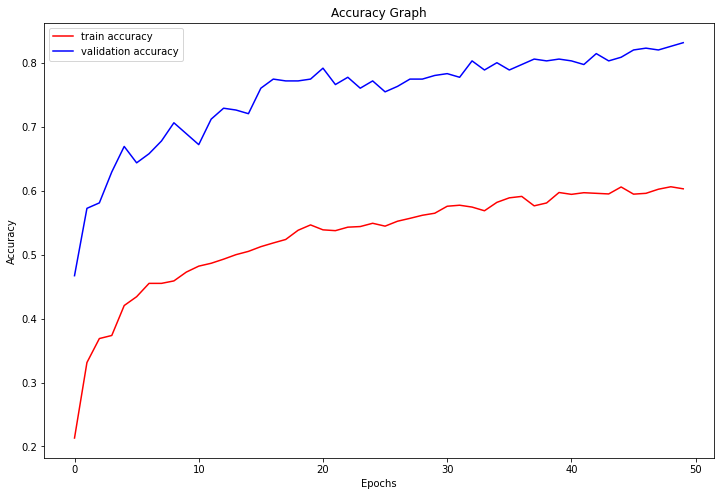

In [ ]:
ㄴplt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

미세조정 동결 일부 해제

In [ ]:
for i, layer in enumerate(resnet_v2.layers):
    print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
46 

In [ ]:
for layer in resnet_v2.layers[350:]:
    layer.trainable = True

base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = Dense(36,kernel_regularizer=regularizers.l2(0.001), activation='softmax')(base_model)

model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
model.summary();

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

동결 해제 후 재 컴파일진행

In [ ]:
history = model.fit(train_images,
              epochs=50,
              batch_size=32,
              validation_data=val_images,
              callbacks=ModelCheckpoint('finetuning_Vegetable_classification.h5', 
                                        monitor='val_accuracy',
                                        mode='max',verbose=1, 
                                        save_best_only=True)
              )

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 3.4750 - accuracy: 0.1512
Epoch 1: val_accuracy improved from -inf to 0.10826, saving model to finetuning_Vegetable_classification.h5
98/98 [==============================] - 140s 1s/step - loss: 3.4750 - accuracy: 0.1512 - val_loss: 48.5670 - val_accuracy: 0.1083
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 2.7079 - accuracy: 0.2844
Epoch 2: val_accuracy improved from 0.10826 to 0.11396, saving model to finetuning_Vegetable_classification.h5
98/98 [==============================] - 128s 1s/step - loss: 2.7079 - accuracy: 0.2844 - val_loss: 164.1735 - val_accuracy: 0.1140
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 2.4296 - accuracy: 0.3483
Epoch 3: val_accuracy improved from 0.11396 to 0.31624, saving model to finetuning_Vegetable_classification.h5
98/98 [==============================] - 130s 1s/step - loss: 2.4296 - accuracy: 0.3483 - val_loss: 48.1807 - val_accuracy: 0

In [ ]:
model.evaluate(test_images)

12/12 [==============================] - 19s 2s/step - loss: 0.4050 - accuracy: 0.9136


[0.4050430357456207, 0.9136490225791931]

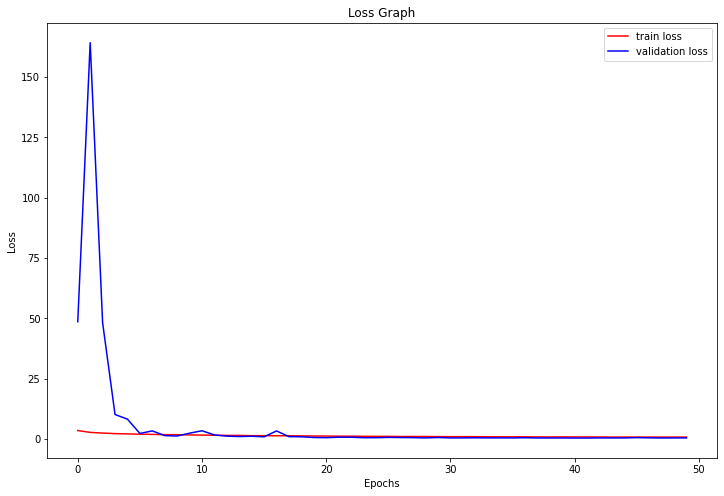

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

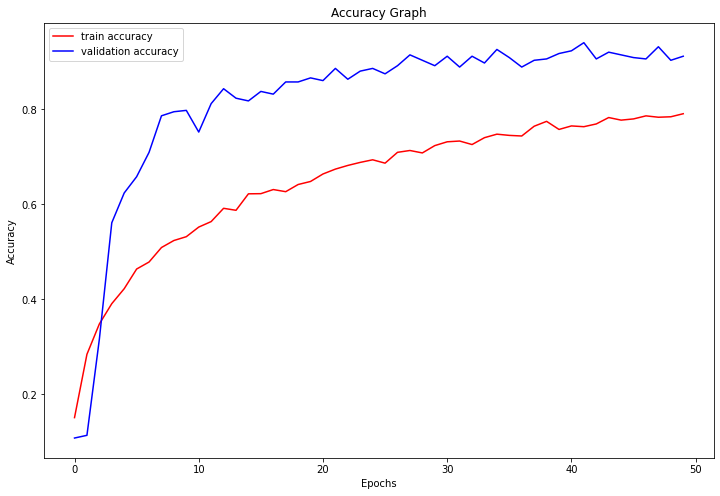

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

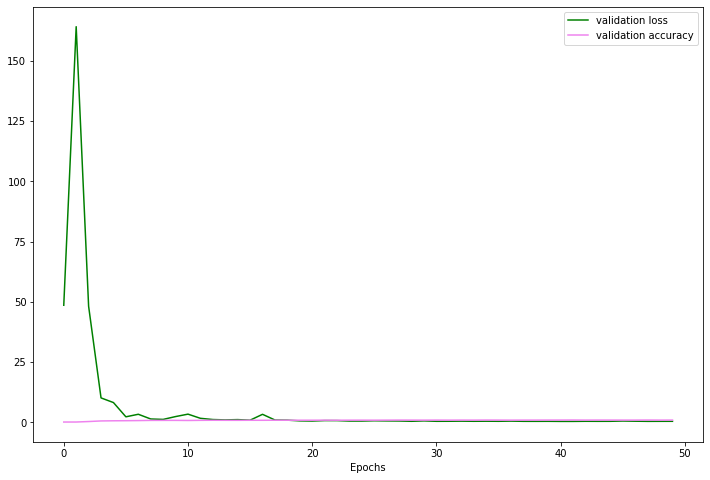

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['val_loss'],'g',label='validation loss')
plt.plot(history.history['val_accuracy'],'violet',label='validation accuracy')
plt.xlabel('Epochs')
plt.legend();